In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
from surprise import Reader, Dataset, SVD, KNNBasic
from surprise.model_selection import train_test_split,GridSearchCV
from surprise import accuracy

# DESCARGA DE DATOS

In [3]:
import kagglehub

path_jokes = kagglehub.dataset_download("vikashrajluhaniwal/jester-17m-jokes-ratings-dataset")
files = []
for dirname, _, filenames in os.walk(path_jokes):
    for filename in filenames:
        file_path = os.path.join(dirname, filename)
        files.append(file_path)
        print(file_path)

c:\Users\home\Documents\IA Aplicada\sistema_recomendacion\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


C:\Users\home\.cache\kagglehub\datasets\vikashrajluhaniwal\jester-17m-jokes-ratings-dataset\versions\3\jester_items.csv
C:\Users\home\.cache\kagglehub\datasets\vikashrajluhaniwal\jester-17m-jokes-ratings-dataset\versions\3\jester_ratings.csv


# EXPLORACION DE DATOS

In [4]:
df_items = pd.read_csv(files[0])
df_ratings = pd.read_csv(files[1])
# Información básica
print(f"reviewers cargados: {len(df_ratings)}")
print(f"chistes cargados: {len(df_items)}")
# Revision de usuarios
if not df_ratings.empty:
    print(f"\nUsuarios únicos: {df_ratings['userId'].nunique():,}")
    print(f"Productos unicos {df_items['jokeId']}")

# Explorar estructura de datos
print(f"\n ESTRUCTURA DE DATOS:")
print(" Columnas en reviews:")
print(f"   {list(df_ratings.columns)}")
print("\n Columnas en metadata:")
print(f"   {list(df_items.columns)}")
print("\n Ratings Max y Min en los chistes:")
print("Valor mínimo:", df_ratings["rating"].min())
print("Valor máximo:", df_ratings["rating"].max())

reviewers cargados: 1761439
chistes cargados: 150

Usuarios únicos: 59,132
Productos unicos 0        1
1        2
2        3
3        4
4        5
      ... 
145    146
146    147
147    148
148    149
149    150
Name: jokeId, Length: 150, dtype: int64

 ESTRUCTURA DE DATOS:
 Columnas en reviews:
   ['userId', 'jokeId', 'rating']

 Columnas en metadata:
   ['jokeId', 'jokeText']

 Ratings Max y Min en los chistes:
Valor mínimo: -10.0
Valor máximo: 10.0


In [5]:
# revision de datos nulos
print(f"Cantidad de ratings_ {len(df_ratings)}")

conteo_nan_ratings = df_ratings.isna().sum()
print(conteo_nan_ratings)

print(f"\nCantidad de metadata: {len(df_items)}")
conteo_nan_metadata = df_items.isna().sum()
print(conteo_nan_metadata)

Cantidad de ratings_ 1761439
userId    0
jokeId    0
rating    0
dtype: int64

Cantidad de metadata: 150
jokeId      0
jokeText    0
dtype: int64


# Preparacion y limpieza de datos

In [6]:
# Análisis de intersección
print(f"reviews unicos: {df_ratings["jokeId"].nunique():,}")
print(f"metadata unicos: {df_items["jokeId"].nunique():,}")

reviews unicos: 140
metadata unicos: 150


In [7]:
# Verificar intersección
common_jokes = set(df_ratings['jokeId']) & set(df_items['jokeId'])
print(f"IDs comunes: {len(common_jokes):,}")

if len(common_jokes) == 0:
    print(" NO HAY INTERSECCIÓN - Creando dataset sintético para el tutorial...")
else:
    # Usar datos reales si hay intersección
    ratings_final = df_ratings[df_ratings['jokeId'].isin(common_jokes)]
    jokes_final = df_items[df_items['jokeId'].isin(common_jokes)]
    print(f" Usando datos reales:")

print(f"    Reviews finales: {len(ratings_final):,}")
print(f"    Productos finales: {len(jokes_final):,}")
print(f"    Usuarios únicos: {ratings_final['userId'].nunique():,}")

IDs comunes: 140
 Usando datos reales:
    Reviews finales: 1,761,439
    Productos finales: 140
    Usuarios únicos: 59,132


# Analisis Exploratorio Adicional

In [8]:
print(" ESTADÍSTICAS GENERALES:")
print(f"    Rating promedio: {ratings_final['rating'].mean():.2f}")
print(f"    Mediana de rating: {ratings_final['rating'].median():.1f}")

# Verificar que hay datos para moda
mode_values = ratings_final['rating'].mode()
if len(mode_values) > 0:
    print(f"    Rating más común: {mode_values.iloc[0]}")
else:
    print(f"    Rating más común: N/A")

# Análisis de actividad
user_activity = ratings_final.groupby('userId').size()
item_popularity = ratings_final.groupby('jokeId').size()

print(f"\n ANÁLISIS DE USUARIOS:")
print(f"    Promedio reviews por usuario: {user_activity.mean():.1f}")
print(f"    Máximo reviews por usuario: {user_activity.max()}")
print(f"    Mínimo reviews por usuario: {user_activity.min()}")

print(f"\n ANÁLISIS DE PRODUCTOS:")
print(f"    Promedio reviews por producto: {item_popularity.mean():.1f}")
print(f"    Producto más popular: {item_popularity.max()} reviews")

 ESTADÍSTICAS GENERALES:
    Rating promedio: 1.62
    Mediana de rating: 2.2
    Rating más común: 9.938

 ANÁLISIS DE USUARIOS:
    Promedio reviews por usuario: 29.8
    Máximo reviews por usuario: 140
    Mínimo reviews por usuario: 1

 ANÁLISIS DE PRODUCTOS:
    Promedio reviews por producto: 12581.7
    Producto más popular: 59122 reviews


In [9]:
# Analizar ratings menores a 0 (los más bajos)
low_ratings = ratings_final[ratings_final['rating'] < 0]
print(f"\n  RATINGS BAJOS (< 0): {len(low_ratings)} registros")
print(f"    Promedio de ratings bajos: {low_ratings['rating'].mean():.2f}")
print(f"    Mediana de ratings bajos: {low_ratings['rating'].median():.2f}")
if not low_ratings.empty:
    print(f"    Rating bajo más común: {low_ratings['rating'].mode().iloc[0]}")
else:
    print("No hay ratings bajos.")

# Análisis de actividad de ratings bajos
user_low_activity = low_ratings.groupby('userId').size()
item_impopularity = low_ratings.groupby('jokeId').size()

print(f"\n ANÁLISIS DE USUARIOS:")
print(f"    Promedio reviews negativo por usuario: {user_low_activity.mean():.1f}")
print(f"    Máximo reviews negativos por usuario: {user_low_activity.max()}")
print(f"    Mínimo reviews negativos por usuario: {user_activity.min()}")

print(f"\n ANÁLISIS DE PRODUCTOS:")
print(f"    Promedio reviews negativos por producto: {item_impopularity.mean():.1f}")
print(f"    Producto más impopular: {item_impopularity.max()} reviews")


  RATINGS BAJOS (< 0): 591780 registros
    Promedio de ratings bajos: -4.58
    Mediana de ratings bajos: -4.28
    Rating bajo más común: -0.031

 ANÁLISIS DE USUARIOS:
    Promedio reviews negativo por usuario: 10.6
    Máximo reviews negativos por usuario: 128
    Mínimo reviews negativos por usuario: 1

 ANÁLISIS DE PRODUCTOS:
    Promedio reviews negativos por producto: 4227.0
    Producto más impopular: 35779 reviews

 ANÁLISIS DE USUARIOS:
    Promedio reviews negativo por usuario: 10.6
    Máximo reviews negativos por usuario: 128
    Mínimo reviews negativos por usuario: 1

 ANÁLISIS DE PRODUCTOS:
    Promedio reviews negativos por producto: 4227.0
    Producto más impopular: 35779 reviews


# Visualizaciones

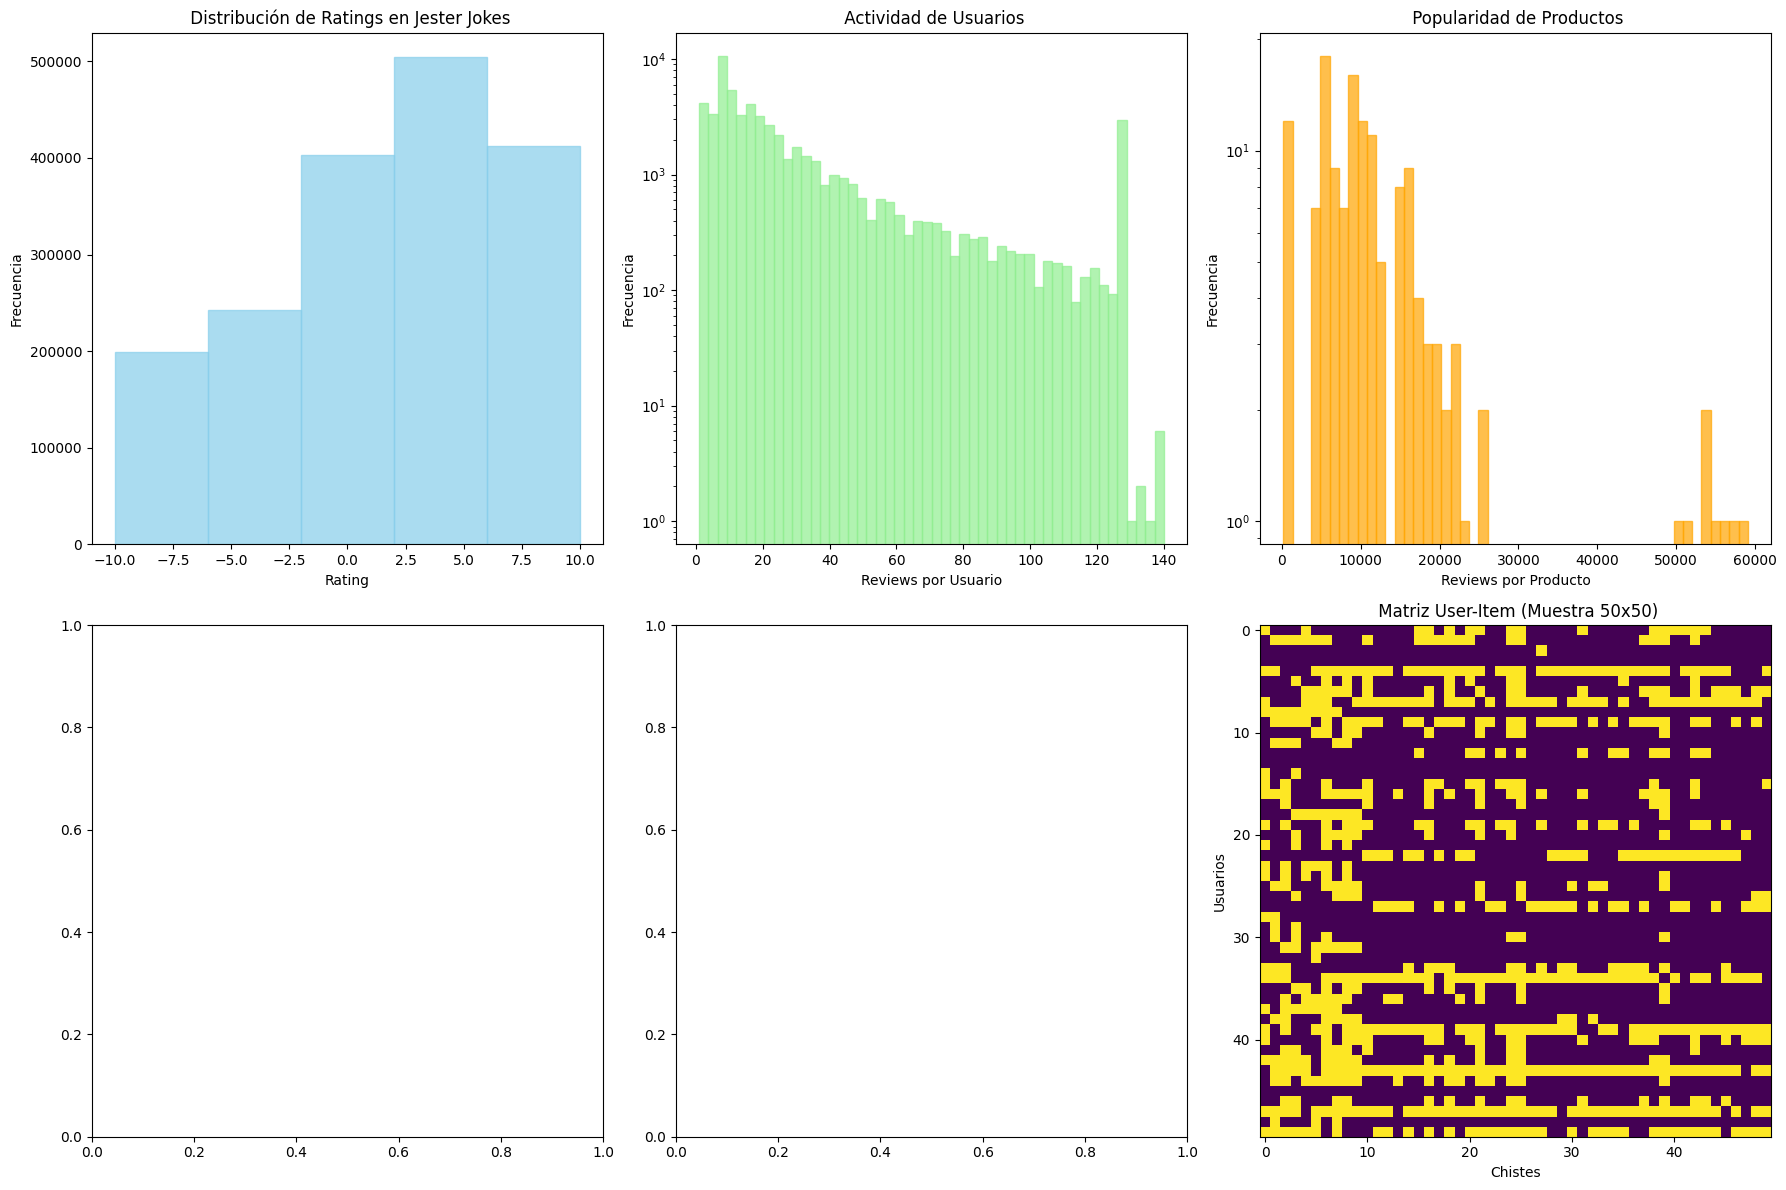

In [10]:
# Visualizaciones
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Distribución de ratings
axes[0,0].hist(ratings_final['rating'], bins=5, edgecolor='skyblue', alpha=0.7, color='skyblue')
axes[0,0].set_title(' Distribución de Ratings en Jester Jokes')
axes[0,0].set_xlabel('Rating')
axes[0,0].set_ylabel('Frecuencia')

# Actividad de usuarios
axes[0,1].hist(user_activity, bins=50, edgecolor='lightgreen', alpha=0.7, color='lightgreen')
axes[0,1].set_title(' Actividad de Usuarios')
axes[0,1].set_xlabel('Reviews por Usuario')
axes[0,1].set_ylabel('Frecuencia')
axes[0,1].set_yscale('log')

# Popularidad de productos
axes[0,2].hist(item_popularity, bins=50, edgecolor='orange', alpha=0.7, color='orange')
axes[0,2].set_title(' Popularidad de Productos')
axes[0,2].set_xlabel('Reviews por Producto')
axes[0,2].set_ylabel('Frecuencia')
axes[0,2].set_yscale('log')


# Matriz de sparsity (muestra)
sample_matrix = ratings_final.pivot_table(
    index='userId', columns='jokeId', values='rating', fill_value=0
).iloc[:50, :50]
axes[1,2].imshow(sample_matrix > 0, cmap='viridis', aspect='auto')
axes[1,2].set_title(' Matriz User-Item (Muestra 50x50)')
axes[1,2].set_xlabel('Chistes')
axes[1,2].set_ylabel('Usuarios')

plt.tight_layout()
plt.show()

In [11]:
# Calcular sparsity (con validación)
total_user = ratings_final['userId'].nunique()
total_items = ratings_final['jokeId'].nunique()
total_ratings = len(ratings_final)
possible_ratings = total_user * total_items

sparsity = 1 - (total_ratings / possible_ratings)
print(f" Sparsity: {sparsity:.2%}")

 Sparsity: 78.72%


In [12]:
# Forma final de reviewers
ratings_final.info()
ratings_final.describe(include="all")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761439 entries, 0 to 1761438
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   userId  int64  
 1   jokeId  int64  
 2   rating  float64
dtypes: float64(1), int64(2)
memory usage: 40.3 MB


,userId,jokeId,rating
count,1.761439e+06,1.761439e+06,1.761439e+06
mean,3.272322e+04,7.071133e+01,1.618602e+00
std,1.828011e+04,4.600790e+01,5.302608e+00
min,1.000000e+00,5.000000e+00,-1.000000e+01
25%,1.720200e+04,2.100000e+01,-2.031000e+00
50%,3.480800e+04,6.900000e+01,2.219000e+00
75%,4.730600e+04,1.120000e+02,5.719000e+00
max,6.397800e+04,1.500000e+02,1.000000e+01


# PREPARACION DEL MODELO BASADO EN USUARIOS Y FACTORIZACION DE MATRICES

In [13]:
# --- PASO 1: Preparar los Datos ---
n_users_sample = 15000
print("Usando ratings_final directamente para Surprise...")
jester_df_wide_sampled = ratings_final.head(n=n_users_sample)

# --- PASO 2: Preparar los datos para la biblioteca Surprise ---
reader = Reader(rating_scale=(-10, 10))
##Datos para  el filtrado colaborativo basado en usuarios
data_sampled = Dataset.load_from_df(jester_df_wide_sampled[['userId', 'jokeId', 'rating']], reader)
trainset_sampled, testset_sampled = train_test_split(data_sampled, test_size=0.2, random_state=42)
##Datos para el modelo Factorizacion de Matrices con SVD
data_full = Dataset.load_from_df(ratings_final[['userId', 'jokeId', 'rating']], reader)
trainset_full, testset_full = train_test_split(data_full, test_size=0.2, random_state=42)

# --- PASO 3: Implementar y Evaluar los Modelos ---
print("\n--- Modelo 1: Filtrado Colaborativo Basado en Memoria (User-Based KNN) ---")
sim_options = {'name': 'pearson_baseline', 'user_based': True, 'min_support': 2}
knn = KNNBasic(sim_options=sim_options, verbose=False) 

# Entrenar el modelo
print("Entrenando el modelo KNN...")
knn.fit(trainset_sampled)

# Realizar predicciones en el conjunto de prueba
print("Evaluando el modelo KNN...")
knn_predictions = knn.test(testset_sampled)

# Calcular y mostrar el error (RMSE)
knn_rmse = accuracy.rmse(knn_predictions)


Usando ratings_final directamente para Surprise...

--- Modelo 1: Filtrado Colaborativo Basado en Memoria (User-Based KNN) ---
Entrenando el modelo KNN...
Evaluando el modelo KNN...
RMSE: 5.1942


In [14]:
# --- PASO 3a: Optimización de Hiperparámetros para SVD ---
print("\n--- Modelo 2: Optimizando Factorización de Matrices (SVD) con GridSearchCV ---")
param_grid = {
    'n_factors': [100],          # Número de factores latentes
    'n_epochs': [20,30],             # Número de iteraciones
    'lr_all': [0.005,0.01],        # Tasa de aprendizaje
    'reg_all': [0.1]          # Término de regularización
}

print("Ejecutando GridSearchCV sobre el conjunto de entrenamiento...")
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)
gs.fit(data_full)

# Obtener el mejor modelo (entrenado con los mejores parámetros)
svd_model = gs.best_estimator['rmse']

# Obtener los mejores parámetros
best_params = gs.best_params['rmse']
print(f"Mejores parámetros encontrados: {best_params}")
# Entrenar el modelo SVD con los mejores parámetros
svd = SVD(**best_params)
svd.fit(trainset_full)
# Evaluar el modelo optimizado en el conjunto de prueba
svd_predictions = svd.test(testset_full)
svd_rmse = accuracy.rmse(svd_predictions)

print(f"RMSE en el conjunto de prueba: {svd_rmse}")



--- Modelo 2: Optimizando Factorización de Matrices (SVD) con GridSearchCV ---
Ejecutando GridSearchCV sobre el conjunto de entrenamiento...
Mejores parámetros encontrados: {'n_factors': 100, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.1}
RMSE: 4.3792
RMSE en el conjunto de prueba: 4.379174708517556


In [15]:
    # --- PASO 4: Comparación y Conclusión ---
print("\n--- Comparación de Resultados ---")
print(f"RMSE del modelo Basado en Memoria (KNN): {knn_rmse:.4f}")
print(f"RMSE del modelo Basado en Modelo (SVD):  {svd_rmse:.4f}")

if svd_rmse < knn_rmse:
    print("\nConclusión: El modelo de Factorización de Matrices (SVD) fue más preciso.")
    best_model = svd
else:
    print("\nConclusión: El modelo Basado en Memoria (KNN) fue más preciso.")
    best_model = knn



--- Comparación de Resultados ---
RMSE del modelo Basado en Memoria (KNN): 5.1942
RMSE del modelo Basado en Modelo (SVD):  4.3792

Conclusión: El modelo de Factorización de Matrices (SVD) fue más preciso.


# Probando con usuarios al Azar para ver su Recomendación

In [21]:
user_id_example = 130
# Obtener las calificaciones del usuario
user_ratings = ratings_final[ratings_final['userId'] == user_id_example]
user_jokes = pd.merge(user_ratings, df_items, on='jokeId')

print(f"Historial de chistes calificados por el usuario {user_id_example}:")
for index, row in user_jokes.head(5).iterrows():
    print(f"id :{row['jokeId']} | Rating: {row['rating']:.4f} | Chiste: '{row['jokeText']}'")

Historial de chistes calificados por el usuario 130:
id :5 | Rating: 7.0620 | Chiste: 'Q.	What's O. J. Simpson's Internet address? 
A.	Slash, slash, backslash, slash, slash, escape.
'
id :7 | Rating: -8.9060 | Chiste: 'How many feminists does it take to screw in a light bulb?
That's not funny.
'
id :8 | Rating: -8.9060 | Chiste: 'Q. Did you hear about the dyslexic devil worshiper? 

A. He sold his soul to Santa.
'
id :13 | Rating: -4.5940 | Chiste: 'They asked the Japanese visitor if they have elections in his
country.  
"Every Morning" he answers.
'
id :15 | Rating: -7.3440 | Chiste: 'Q:  What did the blind person say when given some matzah?

A:  Who the hell wrote this?
'


In [22]:
# Obtener los chistes que el usuario no ha visto
all_joke_ids = ratings_final['jokeId'].unique()
rated_joke_ids = user_ratings['jokeId'].unique()
unrated_joke_ids = [joke_id for joke_id in all_joke_ids if joke_id not in rated_joke_ids]

In [23]:
# Predecir las calificaciones para los chistes no calificados
predictions = []
for joke_id in unrated_joke_ids:
    prediction = svd.predict(uid=user_id_example, iid=joke_id)
    predictions.append(prediction)

# Ordenar las predicciones de mayor a menor
sorted_predictions = sorted(predictions, key=lambda x: x.est, reverse=True)

In [24]:
# Obtener el chiste recomendado (el de mayor predicción)
if sorted_predictions: # Asegurarse de que hay predicciones
    recommended_joke_id = sorted_predictions[0].iid
    recommended_rating = sorted_predictions[0].est
    recommended_joke_text = df_items[df_items['jokeId'] == recommended_joke_id]['jokeText'].iloc[0]

    print("\n--- Recomendación ---")
    print(f"Se recomienda el chiste con ID {recommended_joke_id}.")
    print(f"Calificación predicha: {recommended_rating:.2f}")
    print(f"Chiste recomendado: '{recommended_joke_text}'")
else:
    print("\nNo hay chistes no calificados para recomendar a este usuario.")
    recommended_joke_id = None
    recommended_rating = None
    recommended_joke_text = "No hay recomendación"




--- Recomendación ---
Se recomienda el chiste con ID 60.
Calificación predicha: 7.21
Chiste recomendado: 'What did the Buddhist say to the hot dog vendor?
Make me one with everything.
'


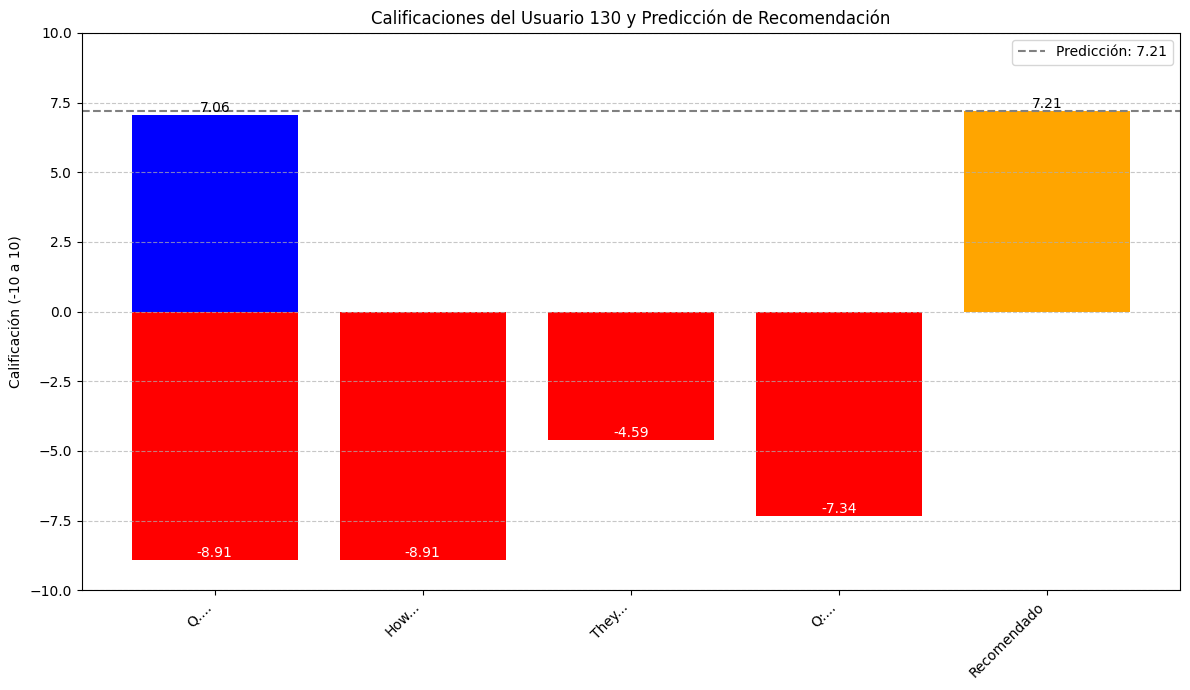

In [ ]:
if recommended_joke_id is not None:
    display_user_jokes = user_jokes.head(5)
    joke_labels = list(display_user_jokes['jokeText'].str.split().str[0] + '...')
    ratings = list(display_user_jokes['rating'])
    joke_labels.append("Recomendado")
    ratings.append(recommended_rating)

    colors = []
    for r in list(display_user_jokes['rating']):
        if r <= 0:
            colors.append('red')
        else:
            colors.append('blue')
    colors.append('orange') # Color para la recomendación

    plt.figure(figsize=(12, 7))
    bars = plt.bar(joke_labels, ratings, color=colors)
    plt.title(f"Calificaciones del Usuario {user_id_example} y Predicción de Recomendación")
    plt.ylabel("Calificación (-10 a 10)")
    plt.ylim(-10, 10)
    plt.axhline(y=recommended_rating, color='gray', linestyle='--', label=f'Predicción: {recommended_rating:.2f}')
    plt.legend()
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Añadir las etiquetas de valor en las barras
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom',
                 color='black' if yval >= 0 else 'white')
    
    plt.show()